In this notebook, we're going to revisit the regression model we trained to predict the UPDRS score of patients with Parkinson's disease from their gait. Most of the code in this notebook is copied from the previous session, but we will use the following techniques to boost the model's performance:
* Imputation of missing data
* Normalizing the feature distributions
* Feature selection



# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install librosa
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -rNcnp https://physionet.org/files/gaitpdb/1.0.0/

--2024-07-24 23:11:43--  https://physionet.org/files/gaitpdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/gaitpdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  36.17K  --.-KB/s    in 0.04s   

Last-modified header missing -- time-stamps turned off.
2024-07-24 23:11:44 (810 KB/s) - ‘physionet.org/files/gaitpdb/1.0.0/index.html’ saved [37036]

Loading robots.txt; please ignore errors.
--2024-07-24 23:11:44--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2024-07-24 23:11:44 (13.3 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2024-07-24 23

# Step 1: Define the Problem You Are Trying to Solve

As before, our overarching goal is to generate a regression model that predicts a person's UPDRSM score based on characteristics of their gait.

In [3]:
# The relevant folders and files associated with this dataset
base_folder = os.path.join('physionet.org', 'files', 'gaitpdb', '1.0.0')
label_filename = os.path.join(base_folder, 'demographics.xls')

In [4]:
# The names of the columns in the recordings
column_names = ['Time']
for i in range(1, 9):
    column_names.append(f'Left Sensor {i}')
for i in range(1, 9):
    column_names.append(f'Right Sensor {i}')
column_names.append('Left Foot')
column_names.append('Right Foot')

In [5]:
# Show the structure of one of the files
example_filename = 'GaCo01_01.txt'
example_df = pd.read_csv(os.path.join(base_folder, example_filename),
                         sep="\t", header=None, names=column_names)
example_df

,Time,Left Sensor 1,Left Sensor 2,Left Sensor 3,Left Sensor 4,Left Sensor 5,Left Sensor 6,Left Sensor 7,Left Sensor 8,Right Sensor 1,Right Sensor 2,Right Sensor 3,Right Sensor 4,Right Sensor 5,Right Sensor 6,Right Sensor 7,Right Sensor 8,Left Foot,Right Foot
0,0.0000,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
1,0.0100,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
2,0.0200,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,660.22,748.00
3,0.0300,199.10,87.34,91.08,24.09,21.12,87.67,89.10,64.57,163.90,77.55,112.42,48.07,13.75,105.49,144.98,79.53,664.07,745.69
4,0.0400,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,77.55,112.42,50.82,13.75,105.49,144.98,79.53,660.22,748.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12114,121.1315,305.91,85.14,58.08,0.00,0.00,0.00,0.00,0.00,15.73,11.66,4.73,33.88,33.00,255.42,432.19,147.29,449.13,933.90
12115,121.1415,331.54,134.75,79.31,11.99,0.00,3.85,0.00,0.00,15.73,9.35,4.73,11.22,24.75,230.34,420.42,151.80,561.44,868.34
12116,121.1515,352.44,181.94,102.96,39.60,0.00,17.49,2.97,0.00,13.97,9.35,4.73,5.61,19.25,192.39,402.82,154.00,697.40,802.12
12117,121.1615,352.44,202.40,124.74,43.01,8.47,50.71,7.59,0.00,13.97,6.93,0.00,0.00,13.75,143.66,373.34,151.80,789.36,703.45


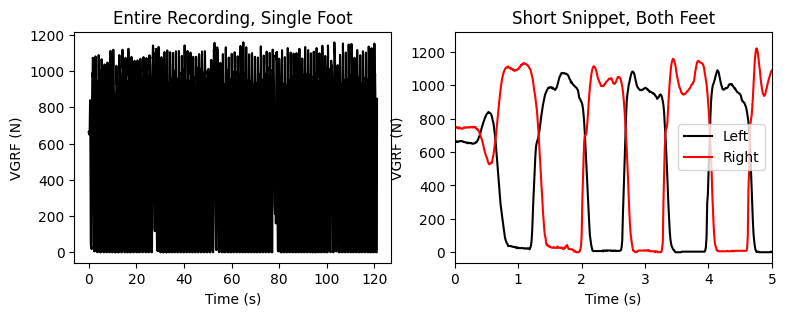

In [6]:
# Plot the data
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Entire Recording, Single Foot')
plt.subplot(1, 2, 2)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.plot(example_df['Time'], example_df['Right Foot'], 'r-', label='Right')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Short Snippet, Both Feet')
plt.xlim(0, 5)
plt.legend()
plt.show()

# Step 2: Create Your Features and Labels

We are going to keep our labels and features the same as before. However, we are going to dive deeper into the availability and the distribution of our data to address some of its limitations.

All of the code from the previous session is copied below, so refer to that notebook if you need a reminder of how we came up with these code blocks.

In [7]:
def compute_arbitrary_time_domain_metrics(times, values, fs=100):
    """
    Calculates generic time-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    return {'average': np.mean(values),
            'stdev': np.std(values),
            '95th percentile': np.percentile(values, 95),
            'rms': np.sqrt(np.mean(values**2))}

In [8]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def compute_arbitrary_freq_domain_metrics(times, values, fs=100):
    """
    Calculates generic frequency-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the indices relevant to our frequency bands of interest
    low_indices = np.where((fft_freqs >= 0) & (fft_freqs <= 3))
    high_indices = np.where((fft_freqs >= 3) & (fft_freqs <= 8))

    # Calculate the power at the low and high frequencies
    low_power = np.sum(fft_mag[low_indices]**2)
    high_power = np.sum(fft_mag[high_indices]**2)

    # Calculate the power within the frequency range
    high_to_low_ratio = 10*np.log10(high_power / low_power)
    return {'power at low freqs': low_power,
            'power at high freqs': high_power,
            'high-to-low power ratio': high_to_low_ratio}

In [9]:
def compute_amplitude_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient amplitude of the signal over time
    using a 5-second window with 0% overlap
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Set the sliding window parameters
    window_width = 5
    start_time = 0
    end_time = window_width
    sample_period = 1/fs
    middle_idx = int((window_width / sample_period) // 2)

    # Stop generating windows it would go past the end of the signal
    window_amplitudes = []
    while end_time < times.max():
        # Grab the current window by filtering indexes according to time
        window_idxs = (times >= start_time) & (times <= end_time)
        window_values = values[window_idxs]

        # Calculate the amplitude
        window_rms = np.sqrt(np.mean(window_values**2))
        window_amplitudes.append(window_rms)

        # Move the window over by a stride
        start_time += window_width
        end_time += window_width

    # Summarize the amplitude over time
    return {'average amplitude': np.mean(window_amplitudes),
            'stdev amplitude': np.std(window_amplitudes)}

In [10]:
def compute_cadence_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient peak frequency of the signal
    over time
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the spectrogram
    values_centered = values - values.mean()
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Find the largest bin along the frequency dimension
    dominant_bins = np.argmax(spectro, axis=0)

    # Map those bin indeces to frequencies
    peak_freqs = spec_freqs[dominant_bins]

    # Summarize the step rate over time
    return {'average cadence': np.mean(peak_freqs),
            'stdev cadence': np.std(peak_freqs)}

In [11]:
def compute_differences(left, right):
    """
    Compares corresponding metrics across two feet
    left: the dictionary of metrics from the left side
    right: the dictionary of metrics from the right side
    """
    diffs_dict = {}
    for key in left:
        diffs_dict[key] = np.abs(left[key] - right[key])
    return diffs_dict

In [12]:
def process_recording(filename):
    """
    Process a VGRF recording and produce all of the features as a dictionary
    (one value per key)
    filename: the name of the recording file
    """
    # Get the useful columns
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    left_values = df['Left Foot'].values
    right_values = df['Right Foot'].values

    # Extract metrics from the left side
    left_time = compute_arbitrary_time_domain_metrics(time, left_values)
    left_freq = compute_arbitrary_freq_domain_metrics(time, left_values)
    left_amplitude = compute_amplitude_metrics(time, left_values)
    left_cadence = compute_cadence_metrics(time, left_values)

    # Extract metrics from the right side
    right_time = compute_arbitrary_time_domain_metrics(time, right_values)
    right_freq = compute_arbitrary_freq_domain_metrics(time, right_values)
    right_amplitude = compute_amplitude_metrics(time, right_values)
    right_cadence = compute_cadence_metrics(time, right_values)

    # Extract difference metrics
    diff_time = compute_differences(left_time, right_time)
    diff_freq = compute_differences(left_freq, right_freq)
    diff_amplitude = compute_differences(left_amplitude, right_amplitude)
    diff_cadence = compute_differences(left_cadence, right_cadence)

    # Combine everything into a dictionary
    feature_dict = {}
    for left_dict in [left_time, left_freq, left_amplitude, left_cadence]:
        for key in left_dict:
            feature_dict['Single foot ' + key] = left_dict[key]
    for diff_dict in [diff_time, diff_freq, diff_amplitude, diff_cadence]:
        for key in diff_dict:
            feature_dict['Difference ' + key] = diff_dict[key]
    return feature_dict

In [13]:
data_filenames = os.listdir(base_folder)

# Iterate through the filenames
features_df = pd.DataFrame()
for data_filename in data_filenames:
    # Skip the file if we want to ignore it
    patient_name = data_filename[0:6]
    patient_type = data_filename[2:4]
    trial_id = data_filename[7:9]
    if (patient_type == 'Co') or (trial_id == '10') or not ('_' in data_filename):
        continue

    # Generate the features
    feature_dict = process_recording(data_filename)

    # Add the patient's name as the identifier
    feature_dict['ID'] = patient_name
    feature_dict = pd.DataFrame([feature_dict])
    features_df = pd.concat([features_df, feature_dict], axis=0)

# Set the index to the image name
features_df.set_index(['ID'], inplace=True)
features_df

,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
JuPt06,534.537118,444.422934,1055.4500,695.155863,3.744240e+12,9.476248e+10,-15.967273,696.113648,7.633290,0.983796,...,25.017293,55.363,30.982237,4.069808e+11,3.773956e+10,1.007740,28.471237,4.087242,0.000000,0.000000
JuPt15,486.480835,416.726086,991.3200,640.565558,7.619441e+12,4.471801e+11,-12.314407,641.247171,25.874385,1.097470,...,15.953624,50.380,18.012111,6.734300e+11,5.028021e+10,0.885833,16.007109,15.249667,0.009301,0.007812
JuPt03,447.612376,376.843962,934.9890,585.122389,1.613765e+12,2.263587e+10,-18.530430,583.417344,15.880433,0.799851,...,18.624460,2.079,13.505802,1.706584e+11,5.524713e+09,1.651754,16.217238,1.799281,0.000000,0.000000
GaPt16,452.808006,388.105046,970.4200,596.372885,1.093209e+13,1.084463e+11,-20.034885,596.426835,13.433749,0.810731,...,36.955258,88.231,49.852721,2.153064e+12,3.011489e+10,0.283512,49.148285,0.196857,0.022111,0.029119
GaPt13,414.537110,347.621438,843.3810,541.000629,8.466057e+12,3.977772e+11,-13.280413,540.497531,8.975412,1.171875,...,0.508819,7.051,3.107320,7.645324e+10,5.364183e+10,0.668149,2.470764,6.030246,0.007370,0.012440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JuPt09,558.228678,485.410645,1235.2285,739.758576,9.561201e+12,7.498571e+11,-11.055340,736.555643,33.089815,1.114710,...,41.804804,104.940,59.526460,1.399534e+12,2.922430e+11,1.457455,56.110457,7.721021,0.000000,0.024739
GaPt07,307.865112,258.855856,686.1910,402.227897,4.826506e+12,8.602649e+10,-17.490007,401.990943,15.265978,0.781250,...,35.847545,49.049,48.585464,1.296596e+12,1.399435e+11,3.160799,48.727985,3.704750,0.000000,0.000000
SiPt23,484.104109,434.620544,1083.5220,650.578055,1.341908e+13,3.021600e+11,-16.474858,650.423460,18.809253,0.781250,...,6.084714,59.521,19.548285,5.289681e+11,2.246317e+11,2.588680,19.222173,0.446086,0.000000,0.000000


In [14]:
labels_df = pd.read_excel(label_filename, index_col='ID')
labels_df

,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10
ID,,,,,,,,,,,,,
GaPt03,Ga,PD,3,female,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,0.778
GaPt04,Ga,PD,4,male,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,0.818
GaPt05,Ga,PD,5,female,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,0.614
GaPt06,Ga,PD,6,male,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,0.937
GaPt07,Ga,PD,7,female,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiCo26,Si,CO,26,male,60,1.74,72.0,NaN,NaN,NaN,9.20,1.000,NaN
SiCo27,Si,CO,27,male,67,1.90,95.0,NaN,NaN,NaN,12.52,1.120,NaN
SiCo28,Si,CO,28,male,61,1.70,72.0,NaN,NaN,NaN,12.65,0.990,NaN


In [15]:
# Keep only patient data
labels_df = labels_df[labels_df['Group'] == 'PD']

# Get rid of unnecessary columns
labels_df = labels_df[['Gender', 'Age', 'Height (meters)',
                       'Weight (kg)', 'UPDRSM']]

# Rename the columns
labels_df.rename(columns={'Gender': 'Sex', 'Height (meters)': 'Height',
                          'Weight (kg)': 'Weight', 'UPDRSM': 'Label'}, inplace=True)
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,female,82,1.45,50.0,10.0
GaPt04,male,68,1.71,NaN,8.0
GaPt05,female,82,1.53,51.0,5.0
GaPt06,male,72,1.70,82.0,13.0
GaPt07,female,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,female,53,1.58,62.0,32.0
SiPt37,female,66,1.70,62.0,21.0
SiPt38,female,65,1.59,60.0,14.0


In [16]:
# Convert gender to a binary sex variable
labels_df['Sex'] = labels_df['Sex'].replace({'male': 0, 'female': 1})
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


In [17]:
# Fix the Ju rows so that the height is in meters
bad_height_rows = labels_df.index.str.startswith('Ju')
labels_df.loc[bad_height_rows, 'Height'] /= 100
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


In [18]:
df = pd.merge(labels_df, features_df, how='right', left_index=True, right_index=True)
df

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1,82,1.45,50.0,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt04,0,68,1.71,NaN,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,0.021288
GaPt05,1,82,1.53,51.0,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,0,72,1.70,82.0,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,1,53,1.67,54.0,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,1,66,1.70,62.0,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,1,65,1.59,60.0,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


## Missing Feature Values

Recall that we have missing entries for some people's UPDRS scores and demographics. We can identify how many rows have missing values in these columns by looking at the "count" row that results from calling the `.describe()` method:

In [19]:
df.describe()

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
count,193.000000,193.000000,187.000000,190.000000,191.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02,...,193.000000,193.000000,193.000000,1.930000e+02,1.930000e+02,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.367876,68.170984,1.684973,73.600000,17.853403,459.235005,394.886791,980.400762,605.783210,9.164032e+12,...,22.597196,50.761922,36.686507,1.043368e+12,5.996502e+10,1.021364,36.455844,3.332920,0.006831,0.010996
std,0.483481,8.652841,0.081803,11.082089,7.050903,70.775602,60.165621,146.240730,92.127219,5.453979e+12,...,19.949744,45.859886,32.328874,1.161468e+12,7.348294e+10,0.951027,32.213411,3.333493,0.009689,0.019635
min,0.000000,36.000000,1.450000,50.000000,5.000000,299.642914,253.370264,667.529500,392.405870,1.036894e+12,...,0.083361,0.220000,0.110271,3.219131e+09,1.078452e+08,0.013493,0.203300,0.003825,0.000000,0.000000
25%,0.000000,64.000000,1.620000,65.000000,12.000000,414.110017,361.418169,884.950000,553.102254,5.891610e+12,...,6.894231,12.650000,12.301520,2.802687e+11,1.135342e+10,0.327729,11.870620,1.096398,0.000000,0.000000
50%,0.000000,68.000000,1.680000,75.000000,16.000000,463.546360,393.993570,959.871000,606.532370,8.376811e+12,...,17.154835,38.467000,28.461464,5.503036e+11,2.656018e+10,0.799875,28.458919,2.424269,0.000000,0.000000
75%,1.000000,74.000000,1.750000,80.000000,23.000000,495.326587,435.506511,1083.093000,658.476025,1.178101e+13,...,31.386604,77.110000,49.371755,1.399534e+12,8.241761e+10,1.370314,49.609170,4.385158,0.010016,0.014412
max,1.000000,84.000000,1.950000,105.000000,44.000000,637.763281,535.453643,1387.771000,831.346507,4.470654e+13,...,94.363098,203.841000,145.296803,5.672494e+12,3.739029e+11,5.401705,146.188386,19.965595,0.044222,0.123768


We will still exclude the patients who did not complete the UPDRS because there is no use in trying to guess what their scores would have been had they completed the assessment.

In [20]:
# Remove rows with missing data
df = df[~pd.isna(df['Label'])]
df

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1,82,1.45,50.0,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt04,0,68,1.71,NaN,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,0.021288
GaPt05,1,82,1.53,51.0,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,0,72,1.70,82.0,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,1,53,1.67,54.0,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,1,66,1.70,62.0,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,1,65,1.59,60.0,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


We will fill in the missing demographic variables with reasonable guesses so that we have access to more data during model training. `scikit-learn` provides a class called `SimpleImputer` that generates reasonable guesses based on the distribution of known values according to a `strategy` like mean or mode. For example, we could fill in missing weights by calculating the average of the weights reported in our dataset.

In [21]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

Because this imputer requires learning from our dataset, it is important that we treat similarly to our machine learning model. In other words, we should only determine the distribution of known values in our training dataset; otherwise, we would be cheating by inspecting our test data before the final evaluation step. Since we are doing k-fold cross-validation, we will add this imputer in Step 8 of this notebook.

## Scaling Feature Values

If we look at the output of the `.describe()` method one more time, you will notice that each column has a very different range.

In [22]:
df.describe()

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
count,191.000000,191.000000,185.000000,188.000000,191.000000,191.000000,191.000000,191.000000,191.000000,1.910000e+02,...,191.000000,191.000000,191.000000,1.910000e+02,1.910000e+02,191.000000,191.000000,191.000000,191.000000,191.000000
mean,0.361257,68.198953,1.685676,73.680851,17.853403,458.950865,394.611716,980.369932,605.389384,9.125348e+12,...,22.527866,50.376026,36.562860,1.035664e+12,6.046301e+10,1.024978,36.330735,3.344942,0.006903,0.011111
std,0.481627,8.613466,0.081858,11.112659,7.050903,71.078548,60.390968,146.881948,92.501234,5.468152e+12,...,19.973514,45.634480,32.289309,1.160681e+12,7.370563e+10,0.955355,32.171178,3.345516,0.009715,0.019706
min,0.000000,36.000000,1.450000,50.000000,5.000000,299.642914,253.370264,667.529500,392.405870,1.036894e+12,...,0.083361,0.220000,0.110271,3.219131e+09,1.078452e+08,0.013493,0.203300,0.003825,0.000000,0.000000
25%,0.000000,64.000000,1.620000,65.000000,12.000000,413.090986,360.429761,883.355000,553.073303,5.869924e+12,...,6.888937,11.913000,12.243699,2.783461e+11,1.132950e+10,0.324448,11.595675,1.114569,0.000000,0.000000
50%,0.000000,68.000000,1.680000,75.000000,16.000000,463.190591,392.818629,959.871000,606.379052,8.341056e+12,...,17.154835,38.467000,28.461464,5.495355e+11,2.700131e+10,0.805553,28.458919,2.424269,0.000000,0.000000
75%,1.000000,74.000000,1.750000,80.250000,23.000000,495.139744,435.409129,1083.307500,658.026140,1.176921e+13,...,31.198020,76.969750,49.208824,1.398623e+12,8.269184e+10,1.379995,49.568164,4.395514,0.010148,0.014412
max,1.000000,84.000000,1.950000,105.000000,44.000000,637.763281,535.453643,1387.771000,831.346507,4.470654e+13,...,94.363098,203.841000,145.296803,5.672494e+12,3.739029e+11,5.401705,146.188386,19.965595,0.044222,0.123768


Some models are inherently robust to feature scaling, such as decision trees and random forests. These models make decisions based on threshold rules, so the scale of one feature does not impact the threshold that is optimal for another feature. Models that rely on distance metrics (e.g., k-nearest neighbors) or linear combinations of features (e.g., linear regression, SVM) can be more sensitive to feature scaling, as features with larger scales may dominate the calculations underlying these models.

While there are ways of making these models account for features with varied scaling, normalizing the scale of our features can prevent this issue and allow models to give appropriate weight to each feature. We will use the `StandardScaler` from `scikit-learn`. This class scales each feature independently such that they look like standard normally distributed data (i.e., Gaussian with 0 mean and unit variance).

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Like our data-driven imputer for filling in missing values, this feature scaling step depends on the distribution of known values in our training dataset. Therefore, we will incorporate this scaler in Step 8 of this notebook.

# Step 3: Decide How the Data Should Be Split for Training and Testing

We will train our model as before, using `GroupKFold` to split our data into 5 folds in a way that keeps samples associated with the same `ID` in the same fold.

# Step 4: (Optional) Add Feature Selection

We intentionally created some features at random and some features inspired by domain expertise. While the number of features we have is still significantly smaller than the number of recordings, fewer features could prevent overfitting and lead to better test accuracy.

We can select features in a variety of ways. We can remove features that are redundant, we can pick features that have a certain amount variance, or we could even pick features according to a second machine learning model.

For simplicity, we will use the `SelectPercentile` class from `scikit-learn`. This feature selector removes all but a user-specified highest scoring percentage of features according to a scoring function (`score_func`). `scikit-learn` provides multiple scoring functions for classification and regression tasks, each with their own mathematical underpininngs. It is important to note that the default scoring function is for classification tasks, so we will need to specify a different one. We will use the `f_regression` score, which determines the utility of each feature according to the F-statistic of univariate linear regression tests.

For this particular feature selector, we also need to carefully consider the percentile we select to dictate how many features we keep. We could treat this number like a model hyperparameter and try different settings to identify the optimal one. For now, however, we will fix this hyperparameter to k=80\%.

In [24]:
from sklearn.feature_selection import SelectPercentile, f_regression
feat_select = SelectPercentile(f_regression, percentile=80)

As with the other feature pre-processing steps we have added, feature selection depends on the distribution of known values in our training dataset. Therefore, we will incorporate this feature selector in Step 8 of this notebook.

# Step 5: (Optional) Balance Your Dataset

We saw that the distribution in UPDRSM scores was fairly normally distributed, so we won't worry about trying to balance our dataset.

# Step 6: Select an Appropriate Model

We will use the same k-nearest neighbors regressor as before.

In [25]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor()

# Step 7: (Optional) Select Your Hyperparameters

We could optimize the hyperparameter `n_neighbors` in our regressor; however, we will skip that step since we already have already made many other changes in our pipeline.

# Step 8: Train and Test Your Model

We will train and test our model as we have in the past, but with three key differences:
1. We will fill in missing demographic values
2. We will scale our features to the same distribution
3. We will apply feature selection to identify the most informative features

The logic of putting imputation first is that the other steps are easiest to work with when the dataset is complete. Since we don't have too much missing data, it is also unlikely that filling in missing values will completely change the scale or utility of those features.

The logic of putting feature scaling before feature selection is that the model will be trained on scaled features rather unscaled ones. Therefore, we should pick which scaled features are most useful.

Depending on how your model pipeline is configured and the type of machine learning model you are using, you might find that a different order may make more sense.

In [26]:
from sklearn.model_selection import GroupKFold

# Get the features, labels, and grouping variables
x = df.drop(['Label'], axis=1).values
y = df['Label'].values
groups = df.index.values

# Initialize a data structure to save our final results,
# assuming all of the predictions are 0 to start
y_pred = np.zeros(y.shape)

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Impute the missing features
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(x_train)
    x_train = imputer.transform(x_train)
    x_test = imputer.transform(x_test)

    # Scale the features
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # Select the most useful features
    feat_select = SelectPercentile(f_regression, percentile=80)
    feat_select.fit(x_train, y_train)
    x_train = feat_select.transform(x_train)
    x_test = feat_select.transform(x_test)

    # Train a model on the transformed training data
    reg = KNeighborsRegressor(n_neighbors=5)
    reg.fit(x_train, y_train)

    # Predict on the transformed test data
    y_test_pred = reg.predict(x_test)
    y_pred[test_idxs] = y_test_pred

As an aside, recall that using cross-validation means that we are training distinct models for each fold of our dataset. Because we are doing feature selection within each fold, we could easily end up selecting different features for each model. This could have implications for how we communicate our results, but since we are focusing on optimizing performance, we will leave things as they are.

# Step 9: Use an Appropriate Method for Interpreting Results

We are going to use the same function we created earlier to view the regression accuracy of our model.

In [27]:
from scipy.stats import pearsonr

def regression_evaluation(y_true, y_pred):
    """
    Generate a series of graphs that will help us determine the performance of
    a regression model
    y_true: the target labels
    y_pred: the predicted labels
    """
    # Calculate the distance metrics and Pearson's correlation
    mean_error = np.mean(y_pred-y)
    std_error = np.std(y_pred-y)
    mean_absolute_error = np.mean(np.abs(y_pred-y))
    corr, pval = pearsonr(y, y_pred)

    # Set up the graphs
    fig_bounds = [y.min()-1, y.max()+1]
    corr_title = f'Correlation = {corr:0.2f}'
    corr_title += ', p<.05' if pval <.05 else ', n.s.'
    ba_title = f'Mean Error = {mean_error:0.2f} ± {std_error:0.2f}'

    # Generate a correlation plot with the scores in the title
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.plot(y, y_pred, '*')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.grid()
    plt.xlim(fig_bounds), plt.ylim(fig_bounds)
    plt.xlabel('Actual Score'), plt.ylabel('Predicted Score')
    plt.title(corr_title)

    plt.subplot(1, 2, 2)
    plt.plot(y, y_pred-y, '*')
    plt.axhline(y=mean_error, color='k', linestyle='--')
    plt.axhline(y=mean_error+std_error, color='r', linestyle='--')
    plt.axhline(y=mean_error-std_error, color='r', linestyle='--')
    plt.xlim(fig_bounds)
    plt.xlabel('Actual Score'), plt.ylabel('Error')
    plt.title(ba_title)
    plt.show()

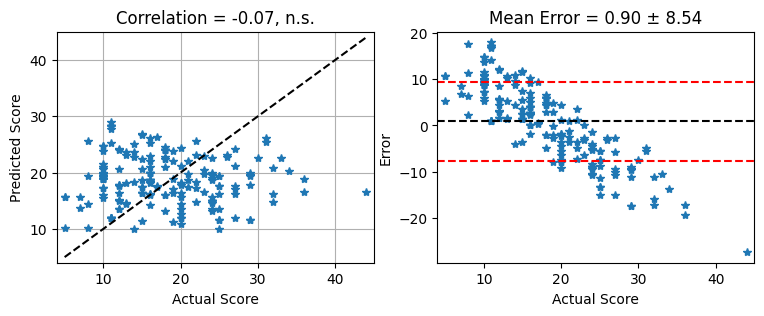

In [28]:
regression_evaluation(y, y_pred)

So after all of that work, we ended up with worse accuracy...what gives? It goes to show that while many of the techniques we have covered sound good in theory, they will not always magically improve the performance of our models. It helps to make these changes incrementally and see what happens along the way.

In this case, it would make sense to re-rerun the code block from Step 8 while trying different combinations of the changes we made to identify where the issues may lie. If you were to do that, you would find out that doing imputation is the main culprit.

From there, it would make sense to see if the imputed values are reasonable and/or whether a different imputation method leads to vastly different results. If you were to do that, you would see that using different imputation methods generally lead to comparable and reasonable results.

Let's take a step back and look at the data that was missing demographic information in the first place:

In [29]:
df = pd.merge(labels_df, features_df, how='right', left_index=True, right_index=True)
df = df[pd.isna(df['Weight']) | pd.isna(df['Height'])]
df

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt04,0,68,1.71,NaN,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,2.128834e-02
GaPt15,0,81,NaN,80.0,20.0,377.583464,321.771720,811.932,496.091032,7.470507e+12,...,92.295240,196.339,127.403211,4.892738e+12,9.723203e+10,0.971836,125.855607,10.544891,0.000000,1.387779e-17
GaPt15,0,81,NaN,80.0,20.0,382.810956,325.978645,814.110,502.798473,7.439453e+12,...,94.363098,203.841,126.749878,4.911676e+12,2.674168e+11,0.547828,125.457957,10.185291,0.036851,1.173285e-02
GaPt19,1,76,NaN,55.0,22.0,364.074204,293.825859,737.550,467.850041,6.090833e+12,...,17.887243,48.312,12.185879,7.868063e+11,1.382543e+10,0.242648,13.109313,6.110617,0.029481,3.888201e-02
GaPt19,1,76,NaN,55.0,22.0,357.622172,294.246318,729.520,463.113931,6.063447e+12,...,29.527356,56.452,36.136945,1.308778e+12,1.886805e+10,0.538465,36.286670,4.542915,0.000000,0.000000e+00
GaPt21,0,80,NaN,63.0,27.0,460.512082,394.727930,978.472,606.532370,1.069604e+13,...,0.798601,48.521,5.238378,1.524170e+11,1.136481e+11,0.799875,6.484262,0.042809,0.014741,1.965523e-03
GaPt21,0,80,NaN,63.0,27.0,455.996318,391.726080,968.990,601.150534,1.088470e+13,...,3.947725,34.210,2.653965,2.305881e+11,1.135342e+10,0.229993,2.105754,0.511609,0.029481,5.095421e-03
GaPt23,1,71,1.60,NaN,25.0,464.688252,326.544906,850.190,567.949599,7.796522e+12,...,5.678751,5.170,47.317984,2.802687e+11,4.771051e+09,0.880084,48.111597,1.992380,0.022111,4.255498e-03
GaPt23,1,71,1.60,NaN,25.0,466.723610,323.447634,849.090,567.846194,7.632565e+12,...,0.294484,9.900,58.050911,2.497121e+10,1.004860e+10,1.095906,59.141813,2.804743,0.022111,5.148877e-03


Here are a few observations:
* All of the participants came from the same cohort: `Ga`.
* The average age across the entire dataset was 68.2 ± 8.7, yet almost half of these patients are over 75.
* The average UPDRSM score across the entire dataset was 17.9 ± 7.1, yet almost half of these patients had scores above 25.

So what does this mean? It could be that by doing imputation and increasing the size of our dataset, we just so happen to be adding anomalous examples back into our training and test folds. Furthermore, these samples are significantly deflating all of our performance metrics because they are coming from individuals with high UPDRSM scores.

Although we would ideally not want to exclude patients from our analyses, let's see what happens when we re-run our supposedly improved pipeline without imputation:

In [30]:
from sklearn.model_selection import GroupKFold

# Generate the original dataset while removing patients with missing features or labels
# (same as in the previous notebook)
df = pd.merge(labels_df, features_df, how='right', left_index=True, right_index=True)
df = df.dropna(how='any')

# Get the features, labels, and grouping variables
x = df.drop(['Label'], axis=1).values
y = df['Label'].values
groups = df.index.values

# Initialize a data structure to save our final results,
# assuming all of the predictions are 0 to start
y_pred = np.zeros(y.shape)

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Scale the features
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # Select the most useful features
    feat_select = SelectPercentile(f_regression, percentile=80)
    feat_select.fit(x_train, y_train)
    x_train = feat_select.transform(x_train)
    x_test = feat_select.transform(x_test)

    # Train a model on the transformed training data
    reg = KNeighborsRegressor(n_neighbors=5)
    reg.fit(x_train, y_train)

    # Predict on the transformed test data
    y_test_pred = reg.predict(x_test)
    y_pred[test_idxs] = y_test_pred

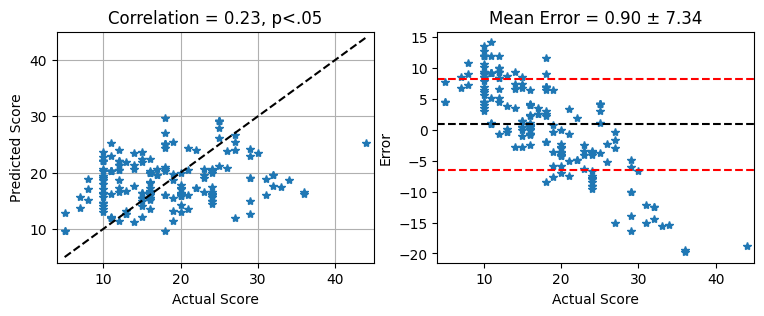

In [31]:
regression_evaluation(y, y_pred)

Now we can see that our model is going somewhere. Although these results aren't amazing, at least we're seeing a statistically significant positive correlation between our predictions and the labels.

The distribution of errors has also changed. The original model from the previous notebook had a mean error of 0.65 ± 7.62, while the corresponding metrics for our current model is 0.90 ± 7.34. Although our new model overpredicts scores a bit more than the previous one, we reduced the standard deviation of those errors by roughly 0.3.

So what are some things we could do to push the performance further? Here are some ideas:
* **Hyperparameter search:** Both our model architecture and the steps that we added had hyperparameters, namely the percentile for the `SelectPercentile` feature selector and the number of neighbors for the `KNearestRegressor` model. We kept these values fixed throughout this notebook, but tuning these numbers could have led to better results.
* **Examine outliers:** We identified outliers in our dataset that worsened the performance of our model. It could be worth our time investigating these individuals more closely and seeing how their features compare to the rest of our dataset. It might also be worth considering if these individuals should be even more represented in our dataset (either by resampling or more data collection).
* **Reconsider the task:** Admittedly, this is not an easy dataset to work with. The UPDRSM examines motor symptoms throughout the body, asking patients to perform tasks ranging from finger tapping and hand movements to leg agility and speech evaluation. We are attempting to predict these comprehensive scores solely using what was measured from the soles of patients' feet while they walked. This doesn't even give us a full picture of their gait, as we're missing out on the length of their stride and the angles of their joints. Perhaps we need more signals to get a meaningful model? Perhaps we should be trying classification (high vs. low score) instead of regression?